# Overfitting Demo
### Create a dataset based on a true sinusoidal relationship
Let's look at a synthetic dataset consisting of 30 points drawn from sinusoid y = sin(4x) 

In [20]:
import graphlab
import math
import random
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

Create random values for x in interval [0, 1)

In [21]:
random.seed(98103)
n = 30
x = graphlab.SArray([random.random() for i in range(n)]).sort()

Compute y

In [22]:
y = x.apply(lambda x: math.sin(4*x))

Add random Gaussian Noise to y

In [23]:
random.seed(1)
e = graphlab.SArray([random.gauss(0, 1.0/3.0) for i in range(n)])
y = y + e 

### Put data into an SFrame to manipulate later

In [24]:
data = graphlab.SFrame({'X1': x, 'Y': y})
data

X1,Y
0.0395789449501,0.587050191026
0.0415680996791,0.648655851372
0.0724319480801,0.307803309485
0.150289044622,0.310748447417
0.161334144502,0.237409625496
0.191956312795,0.705017157224
0.232833917145,0.461716676992
0.259900980166,0.383260507851
0.380145814869,1.06517691429
0.432444723508,1.03184706949


### Create a function to plot the data since we'll do it many times

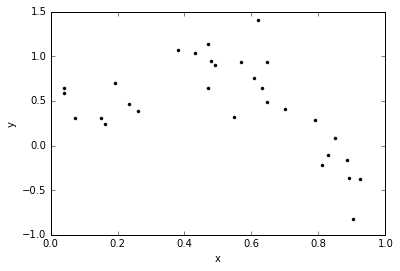

In [25]:
def plot_data(data):
    plt.plot(data['X1'], data['Y'], 'k.')
    plt.xlabel('x')
    plt.ylabel('y')
    
plot_data(data)

### Define some useful polynomial regression functions
Define a function to create our features for a polynomial regression model for any degree: 

In [26]:
def polynomial_features(data, deg):
    data_copy = data.copy()
    for i in range(1, deg):
        data_copy['X' + str(i+1)] = data_copy['X' + str(i)] * data_copy['X1']
    return data_copy 

Define a function to fit a polynomial linear regression model of degree 'deg' to the data in 'data'

In [27]:
def polynomial_regression(data, deg):
    model = graphlab.linear_regression.create(polynomial_features(data, deg), 
                                             target='Y',
                                             l2_penalty=0.,
                                             l1_penalty=0.,
                                             validation_set=None,
                                             verbose=False)
    return model

Define a function to plot data and predictions made, since we are going to use it many times

In [28]:
def plot_poly_predictions(data, model):
    plot_data(data)
    
    #get the degree of the polynomial
    deg = len(model.coefficients['value']) - 1
    
    #create 200 points in the x axis and compute the predicted value for each point
    x_pred = graphlab.SFrame({'X1': [i/200.0 for i in range(200)]})
    y_pred = model.predict(polynomial_features(x_pred, deg))
    
    #plot predicitons
    plt.plot(x_pred['X1'], y_pred, 'g-', label='degree ' + str(deg) + ' fit')
    plt.legend(loc='upper left')
    plt.axis([0, 1, -1.5, 2])

Create a function that prints the polynomial coefficients in a pretty way

In [29]:
def print_coefficients(model):
    #get the degree of the polynomial 
    deg = len(model.coefficients['value']) - 1
    
    #get learned parameters as a list
    w = list(model.coefficients['value'])
    
    #numpy has a nifty function to print out polynomials in a pretty way
    # (we'll use it but it needs parameters in reverse order)
    print 'learned polynomial for degree ' + str(deg) + ':'
    w.reverse()
    print numpy.poly1d(w)

## Fit a degree-2 polynomial 
Fit our degree-2 polynomial with the data generated above:

In [30]:
model = polynomial_regression(data, deg=2)

Inspect learned parameters 

In [31]:
print_coefficients(model)

learned polynomial for degree 2:
        2
-5.129 x + 4.147 x + 0.07471


Form and plot our predictions along a grid of x values

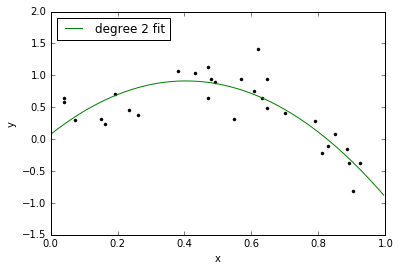

In [32]:
plot_poly_predictions(data, model)

## Fit a degree-4 Polynomial 

learned polynomial for degree 4:
       4         3         2
23.87 x - 53.82 x + 35.23 x - 6.828 x + 0.7755


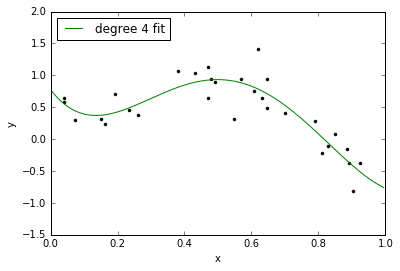

In [33]:
model = polynomial_regression(data, deg=4)
print_coefficients(model)
plot_poly_predictions(data, model)

## Fit a degree-16 Polynomial

learned polynomial for degree 16:
           16             15             14             13
2.583e+06 x  - 1.092e+07 x  + 1.443e+07 x  + 1.873e+06 x 
              12             11             10             9
 - 2.095e+07 x  + 1.295e+07 x  + 9.366e+06 x  - 1.232e+07 x
              8             7             6             5             4
 - 2.544e+06 x + 1.181e+07 x - 9.325e+06 x + 3.887e+06 x - 9.666e+05 x
              3             2
 + 1.441e+05 x - 1.215e+04 x + 506.6 x - 7.325


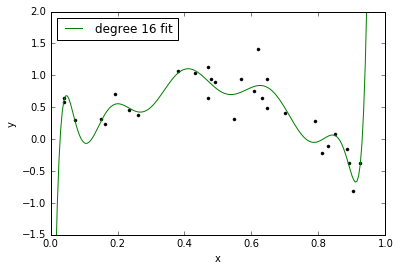

In [34]:
model = polynomial_regression(data, deg=16)
print_coefficients(model)
plot_poly_predictions(data, model)

## Ridge Regression 
Ridge regression aims to avoid overfitting by adding a cost ot the RSS term of a standard least squares that depends on the 2-norm of the coefficents ||w||.  The result is penalizing fits with large coefficients.  The strength of this penalty, and thus the fit vs. model complexity balance is controled by a paramter lambda (here called 'L2_penalty'). 

Define our function to solve the ridge objective for a polynomial regression model of any degree:

In [35]:
def polynomial_ridge_regression(data, deg, l2_penalty):
    model = graphlab.linear_regression.create(polynomial_features(data, deg),
                                             target='Y',
                                             l2_penalty=l2_penalty,
                                             validation_set=None,
                                             verbose=False)
    return model

### Perform a ridge fit of a degree-16 polynomial using a very small penalty strength

In [36]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=1e-25)
print_coefficients(model)

learned polynomial for degree 16:
           16             15             14             13
2.583e+06 x  - 1.092e+07 x  + 1.443e+07 x  + 1.873e+06 x 
              12             11             10             9
 - 2.095e+07 x  + 1.295e+07 x  + 9.366e+06 x  - 1.232e+07 x
              8             7             6             5             4
 - 2.544e+06 x + 1.181e+07 x - 9.325e+06 x + 3.887e+06 x - 9.666e+05 x
              3             2
 + 1.441e+05 x - 1.215e+04 x + 506.6 x - 7.325


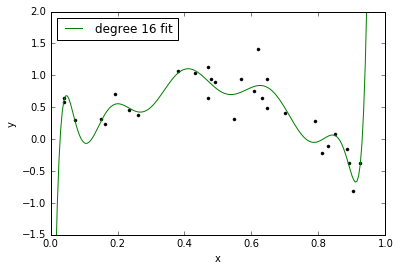

In [37]:
plot_poly_predictions(data, model)

### Perform a ridge fit of a degree-16 polynomial using a very large penalty strength

In [38]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=100)
print_coefficients(model)

learned polynomial for degree 16:
        16          15          14          13          12         11
-0.301 x  - 0.2802 x  - 0.2604 x  - 0.2413 x  - 0.2229 x  - 0.205 x 
           10          9          8          7          6           5
 - 0.1874 x  - 0.1699 x - 0.1524 x - 0.1344 x - 0.1156 x - 0.09534 x
            4           3           2
 - 0.07304 x - 0.04842 x - 0.02284 x - 0.002257 x + 0.6416


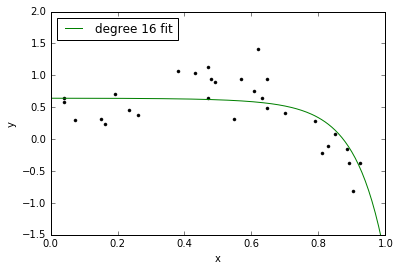

In [39]:
plot_poly_predictions(data, model)

### Let's look at fits for a sequence of increasing lambda values

lambda = 1.00e-25
learned polynomial for degree 16:
           16             15             14             13
2.583e+06 x  - 1.092e+07 x  + 1.443e+07 x  + 1.873e+06 x 
              12             11             10             9
 - 2.095e+07 x  + 1.295e+07 x  + 9.366e+06 x  - 1.232e+07 x
              8             7             6             5             4
 - 2.544e+06 x + 1.181e+07 x - 9.325e+06 x + 3.887e+06 x - 9.666e+05 x
              3             2
 + 1.441e+05 x - 1.215e+04 x + 506.6 x - 7.325


lambda = 1.00e-10
learned polynomial for degree 16:
           16             15             14             13
4.975e+04 x  - 7.821e+04 x  - 2.265e+04 x  + 3.949e+04 x 
              12        11             10             9             8
 + 4.366e+04 x  + 3080 x  - 3.333e+04 x  - 2.785e+04 x + 1.032e+04 x
              7        6             5             4        3         2
 + 2.962e+04 x - 1441 x - 2.597e+04 x + 1.839e+04 x - 5596 x + 866.1 x - 65.19 x + 2.159


lambda = 1.00e-06

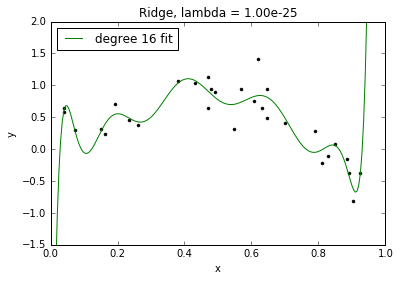

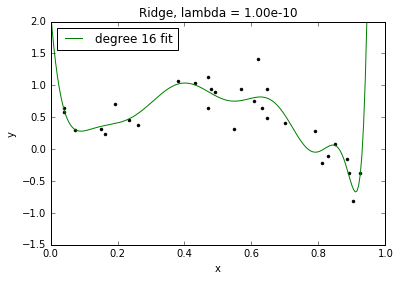

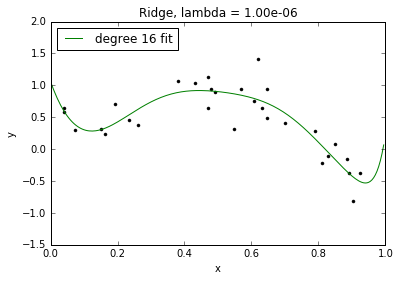

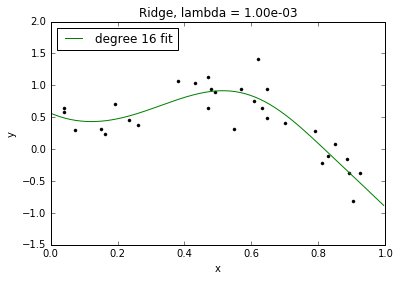

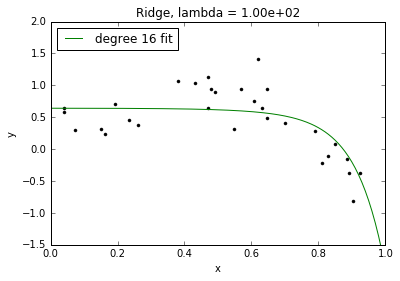

In [40]:
for l2_penalty in [1e-25, 1e-10, 1e-6, 1e-3, 1e2]:
    model = polynomial_ridge_regression(data, deg=16, l2_penalty=l2_penalty)
    print 'lambda = %.2e' % l2_penalty
    print_coefficients(model)
    print '\n'
    plt.figure()
    plot_poly_predictions(data, model)
    plt.title('Ridge, lambda = %.2e' % l2_penalty)

### Perform a ridge fit of a degree-16 polynomial using a 'good' penalty strength

We will learn about cross-validation later in this course as a way to select a good value of the tuning parameter (penalty strength) lambda.  Here, we consider 'leave one out' (LOO) cross-validation, which can show approximates average mean square error (MSE).  As a result, choosing lambda to minimize the LOO error is equivalent to choosing lambda to minimize an approximation to average MSE.

In [42]:
#LOO cross validation -- return the average MSE
def loo(dat, deg, l2_penalty_values):
    #create polynomial features
    polynomial_features(data, deg)
    
    #create as many folds for cross validation as number of data points
    num_folds = len(data)
    folds = graphlab.cross_validation.KFold(data, num_folds)
    
    #for each value of l2_penalty, fit a model for each fold and compute average MSE
    l2_penalty_mse = []
    min_mse = None
    best_l2_penalty = None
    for l2_penalty in l2_penalty_values:
        next_mse = 0.0
        for train_set, validation_set in folds:
            #train model
            model = graphlab.linear_regression.create(train_set,
                                                     target='Y',
                                                     l2_penalty=l2_penalty,
                                                     validation_set=None,
                                                     verbose=False)
            
            #predict on validation set
            y_test_predicted = model.predict(validation_set)
            
            #compute squared error
            next_mse += ((y_test_predicted-validation_set['Y'])**2).sum()
            
        #save squared error in list of MSE for each l2_penalty
        next_mse = next_mse/num_folds
        l2_penalty_mse.append(next_mse)
        if min_mse is None or next_mse < min_mse:
            min_mse = next_mse
            best_l2_penalty = l2_penalty
            
    return l2_penalty_mse, best_l2_penalty

Run LOO cross validation for 'num' values of lambda on a log scale

In [43]:
l2_penalty_values = numpy.logspace(-4, 10, num=10)
l2_penalty_mse, best_l2_penalty = loo(data, 16, l2_penalty_values)

Plot results of estimating LOO for each value of lambda

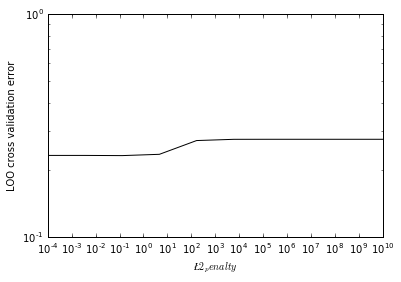

In [45]:
plt.plot(l2_penalty_values, l2_penalty_mse, 'k-')
plt.xlabel('$\L2_penalty$')
plt.ylabel('LOO cross validation error')
plt.xscale('log')
plt.yscale('log')

Find the value of lambda, that minamizes the LOO cross validaiton error, and plot resulting fit

In [46]:
best_l2_penalty

0.12915496650148839

In [47]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=best_l2_penalty)
print_coefficients(model)

learned polynomial for degree 16:
       16         15          14          13          12           11
1.345 x  + 1.141 x  + 0.9069 x  + 0.6447 x  + 0.3569 x  + 0.04947 x 
           10          9          8         7         6         5
 - 0.2683 x  - 0.5821 x - 0.8701 x - 1.099 x - 1.216 x - 1.145 x
           4           3          2
 - 0.7837 x - 0.07406 x + 0.7614 x + 0.7703 x + 0.3918


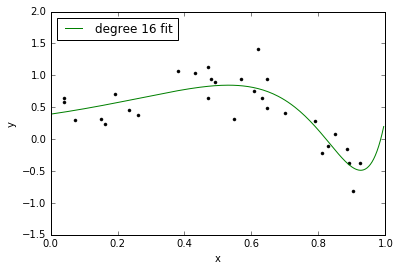

In [48]:
plot_poly_predictions(data, model)